# **Pràctica 2 - L'enfonsament del Titànic i les possiblitats de sobreviure**
## Inteligència Artificial - Machine Learning
### Grau en Enginyeria Informàtica - Universitat de les Illes Balears

#### Autors: Lluis Barca Pons i Victor Canelo Galera

Desde l'assignatura d'Intelgència Artificial se'ns ha demanat realitzar un anàlisis sobre el famós enfonsament del vaixell Titànic, l'any 1912. Durant aques naufragi, van morir 1502 de 2224 persones registrades, entre passatgers i tripulants.

El més interessant és que sembla ser que existia diferents probabilitats de sobreviure entre alguns grups de persones. Per tant, l'objectiu d'aquesta pràctica és realitzar un model predictiu, utilizant les dades reals recollides, que ens mostri quins tipus de persones tenien més probabiitats de viure.

Llavors, la practica es dividira en dues parts:

1. Entrenar una serie de predictors i comparar el seu rendiment.

2. Obtenir i analitzar la importancia de cada caracteristica per cada un dels models generats.

# 1. Primera part

Per a la configuració del nostre entorn, necessitarem els corresponents imports de les diferents llibreries de Python que utilitzarem durant tota la pràctica.

In [ ]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

## 1.1. Neteja del dataset

In [ ]:
df = pd.read_csv("dades.csv")
df

En primer lloc, comprovarem si tenim alguna columna del nostre dataset amb algun valor NaN (no numèric):

In [ ]:
df.isnull().any()

Ens adonam que tres de les dotze variables tenen valors no numèrics. Però, ens interessa saber quin tant per cent de les files no ens donen cap informació, ja que podria ser una informació d'útilitat per descartar directament qualque variable.

In [ ]:
na_ratio = ((df.isnull().sum() / len(df))*100).sort_values(ascending = False)
print(na_ratio)

Analitzam els valors no numèrics de les tres primeres variables:

- **Cabin**: Els valors no numèrics ens indiquen realment que aquell passatger no tenia cabina (camarot). Llavors, realment un 77% dels passatgers anaven sense cabina. Això ens indica que no és necessari eliiminar aquesta variable (de primeres), ja que ens podria estar donant una informació útil; que valorarem en fer la correlació. El que farem serà modificar la taula i els passatgers amb valor no numèric passaran a tenir un 0 i els que tinguin qualque cabina 1. D'aquesta manera sabrem quin passatger té o no cabina.
- **Age**: L'edat sol ser una informació de gran valor, ja que ens podria donar molta informació de quin grup de persones tenen més probabilitats de sobreviure. Per tant, haurem de substituir els valors no numèrics per la mitjana d'edat de la resta de persones al vaixell; amb l'objectiu de minimitzar l'impacte que podrien tenir en els nostres resultats aquesta falta d'informació d'alguns tripulants.
- **Embarked**: Aquesta variable ens aporta poca infromació útil, degut a que no hi ha una relació directe entre les persones que embarquen en *x* port, amb la probabilitat de sobreviure. El vaixell es va enfonsar en mig de l'Atlàntic, i a causa d'un iceberg. Però, no la descartarem fins a realitzar la respectiva correlacio, i com el nombre de valors no numèrics és insignficiant, tampoc la netejarem.

A continuació, el procés de neteja del dataset:

In [ ]:
model = df

# Eliminam les variables PassengerId, Name i Ticket
del model["PassengerId"]
del model["Name"]
del model["Ticket"]

# Calculam la mitjana d'edat de la gent del vaixell
edat = model[["Age"]]
edat = edat.dropna()
edat = int(edat.mean())
edat = float(edat)

# Modificam els valors no numèrics per la mitjana
model["Age"] = model["Age"].replace(np.nan, edat)

# Modificam el valor Cabin
model["Cabin"] = model["Cabin"].notnull().astype("int")

model


## 1.2. Caracterització de les dades

Realtizarem la caracterització de les variables categòriques:

In [ ]:
model["Fare"] = pd.cut(model["Fare"], bins=[0, 7.91, 14.45, 31, 120], labels=["Low", "Median", "Average", "High"])

model["Age"] = pd.cut(model["Age"], bins=[0, 12, 18, 40, 100], labels=["Kid", "Teen", "Adult", "Old"])

model = pd.get_dummies(model, columns=["Pclass", "Sex", "Age", "Fare", "Embarked"], prefix=["Pclass", "Sex", "Age", "Fare_type", "Embarked"])

model

## 1.3. Anàlisis del dataset

En primer lloc realitzarem una correlacio de totes les variables per analitzar quines ens poden interessar i quines no:

In [ ]:
corr_fig = plt.figure(figsize=(15,15))
sns.heatmap(model.corr(), annot=True, square=True, cmap="RdYlGn", linewidths=0.2)

A continuació realitzarem una segona correlació amb una variable nova. Aquesta serà la variable Family, que es crearà a partir de la suma de la variable Sibsp i Parch. L'objectiu d'aquesta prova és comprobar si el fet de tenir o no familiars a bord, va ser un motiu de pes a l'hora de sobreviure. Intuitivament podriem pensar que si, però hem de comprovar-ho.

In [ ]:
sibsp = model["SibSp"]
parch = model["Parch"]
family = []

# Cream la nova columna family
for i in range(len(sibsp)):
    family.append(sibsp[i] + parch[i])

# Eliminam les variables sibsp i parch del dataset
del model["SibSp"]
del model["Parch"]

# Afegim la columna family
model.insert(5, "Family", family, True)

model

Tornam a fer la correlació amb la nova variable:

In [ ]:
corr_fig = plt.figure(figsize=(15,15))
sns.heatmap(model.corr(), annot=True, square=True, cmap="RdYlGn", linewidths=0.2)

Llavors ens adonem que aquesta variable no afecta pràcticament i per tant podriem descartar-la. Llavors, les variables que més ens interessen són les que comparades amb "Survived", prenen valors o molt a prop de 1 o de -1; és a dir, que tindran molta correlació.

In [ ]:
model

Per tant, podem descartar també les següents variables:

In [ ]:
model_fit = model.copy()

del model_fit["Pclass_2"]
del model_fit["Family"]
del model_fit["Age_Kid"]
del model_fit["Age_Teen"]
del model_fit["Age_Adult"]
del model_fit["Age_Old"]
del model_fit["Fare_type_Median"]
del model_fit["Fare_type_Average"]
del model_fit["Embarked_Q"]

model_fit

Com ens queda un dataset bastant petit, hem decidt realitzar la part d'entrenament tant amb el dataset complet, com amb el que hem filtrat prèviament. Després de fer els respectius entrenaments amb els diferents models, escollirem el model que més precissió ens doni.

# 2. Entrenament

## 2.1. Model complet

En aquest apartat es duran a terme una serie d'entrenaments segons diferents predictors i finalment es comparan els seus rendiments. Abans però, haurem de separar el nostre conjunt de dades per a entrenament, validació i testeig. També normalitzarem les dades per a que les poguem comparar entre elles.

In [ ]:
scaler = preprocessing.MinMaxScaler()

y = model["Survived"]
x = model.drop("Survived", axis=1)

# Escalam les dades en funció de x
x = scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y , random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

### 2.1.1. Regressió Logística

A la biblioteca scikit-learn, la classe LogisticRegression s'utilitza per implementar la regressió logística. Aquesta classe proporciona diversos hiperparàmetres que ens permeten personalitzar el comportament del model.

Aquests són alguns dels hiperparàmetres principals de la classe LogisticRegression:

- **penalty**: Aquest hiperparàmetre especifica el tipus de regularització a utilitzar. Els valors possibles són "*l1*" per a la regularització L1 i "*l2*" per a la regularització L2. La regularització L1 afegeix una penalització basada en el valor absolut dels coeficients, mentre que la regularització L2 afegeix una penalització basada en el quadrat dels coeficients.

- **C**: Aquest hiperparàmetre controla la força de la regularització. Un valor més petit de C correspon a una regularització més forta, que pot ajudar a evitar el sobreajustament.

- **solver**: Aquest hiperparàmetre especifica l'algorisme a utilitzar per a l'optimització. Els valors possibles són "*newton-cg*", "*lbfgs*", "*liblinear*" i "*sag*".

- **max_iter**: Aquest hiperparàmetre especifica el nombre màxim d'iteracions a utilitzar quan s'ajusta el model.

- **tol**: Aquest hiperparàmetre especifica la tolerància per a l'optimització. Si la diferència entre la funció de cost en dues iteracions consecutives és menor que la tolerància, l'optimització s'aturarà.

- **multi_class**: Aquest hiperparàmetre especifica l'estratègia a utilitzar quan hi ha diverses classes. Els valors possibles són 'ovr' per a un contra repòs i 'multinomial' per a la pèrdua multinomial.

- **fit_intercept**: Aquest hiperparàmetre especifica si s'ha d'ajustar un terme d'intercepció al model.

- **class_weight**: Aquest hiperparàmetre us permet especificar pesos de classe per equilibrar la distribució de classes a les dades d'entrada.

És important ajustar aquests hiperparàmetres amb cura, ja que poden afectar significativament el rendiment del model

In [ ]:
warnings.filterwarnings("ignore")

params = {
    "penalty" : ["l1", "l2", "elasticnet", None],
    "tol" : [0.000001, 0.00001, 0.0001, 0.001],
    "C" : [0.1, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25],
    "fit_intercept" : [True, False],
    "class_weight" : ["balanced", None],
    "solver" : ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"],
    "max_iter" : [20, 25, 50, 100],
    "multi_class" : ["auto", "ovr", "multinomial"],
}

grid = GridSearchCV(estimator=LogisticRegression(), param_grid=params, n_jobs=4)

grid.fit(x_train, y_train)

print(grid.best_params_)
grid.best_score_

Aplicam els paràmetres òptims aconseguits:

In [ ]:
log = LogisticRegression(
    C= 0.22, class_weight=None, 
    fit_intercept=True, 
    max_iter= 20, 
    multi_class="auto",
    penalty="l1",
    solver="liblinear",
    tol=0.000001,
    random_state=42).fit(x_train, y_train)
y_hat = log.predict(x_test)

# Array de 10 valors per fer-ne la mitjana per a la posterior comparació de rendiments
logistic_predicts = []
for i in range(10):
    logistic_predicts.append(round(accuracy_score(log.predict(x_test),y_test)*100,2))

log_pred = np.array(logistic_predicts).mean()

print(f"La precissió és del {log_pred}%")

### 2.1.2 Perceptró

A la biblioteca scikit-learn, la classe *Perceptron* s'utilitza per implementar un model de perceptron d'una sola capa. Aquesta classe proporciona diversos hiperparàmetres que ens permeten personalitzar el comportament del model.

Aquests són alguns dels principals hiperparàmetres de la classe *Perceptron*:

- **penalty**: Aquest hiperparàmetre especifica el tipus de regularització a utilitzar. Els valors possibles són "*l1*" per a la regularització L1 i "*l2*" per a la regularització L2. La regularització L1 afegeix una penalització basada en el valor absolut dels coeficients, mentre que la regularització L2 afegeix una penalització basada en el quadrat dels coeficients.

- **alpha**: Aquest hiperparàmetre controla la força de la regularització. Un valor més petit d'alfa correspon a una regularització més forta, que pot ajudar a evitar el sobreajust.

- **fit_intercept**: Aquest hiperparàmetre especifica si s'ha d'ajustar un terme d'intercepció al model.

- **max_iter**: Aquest hiperparàmetre especifica el nombre màxim d'iteracions a utilitzar quan s'ajusta el model.

- **tol**: Aquest hiperparàmetre especifica la tolerància per a l'optimització. Si la diferència entre la funció de cost en dues iteracions consecutives és menor que la tolerància, l'optimització s'aturarà.

- **shuffle**: Aquest hiperparàmetre especifica si s'han de barrejar les dades d'entrenament abans d'ajustar el model.

- **early_stopping**: Aquest hiperparàmetre especifica si s'ha d'utilitzar l'aturada anticipada per finalitzar el procés d'ajust quan la puntuació de validació no millora.

- **validation_fraction**: Aquest hiperparàmetre especifica la fracció de les dades d'entrenament que cal utilitzar per a la validació quan l'aturada anticipada està habilitada.

És important ajustar aquests hiperparàmetres amb cura, ja que poden afectar significativament el rendiment del model.

In [ ]:
warnings.filterwarnings("ignore")

params = {
    "penalty" : ["l2", "l1", "elasticnet", None],
    "alpha" : [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1],
    "fit_intercept" : [True, False],
    "max_iter" : [50, 100, 150, 200],
    "tol" : [0.0001, 0.001, 0.01, 0.1],
    "shuffle" : [True, False],
    "early_stopping" : [True, False],
    "validation_fraction" : [0.00001, 0.0001, 0.001, 0.1],
}

grid = GridSearchCV(estimator=Perceptron(), param_grid=params, n_jobs=4)

grid.fit(x_train, y_train)

print(grid.best_params_)
grid.best_score_

Aplicam els paràmetres òptims aconseguits:

In [ ]:
perc = Perceptron(
    alpha=0.0001, 
    early_stopping=False, 
    fit_intercept=False, 
    max_iter=50, 
    penalty="l1", 
    shuffle=True,
    tol=0.0001,
    validation_fraction=0.00001,
    random_state=42).fit(x_train, y_train)
y_hat = perc.predict(x_test) 

# Array de 10 valors per fer-ne la mitjana per a la posterior comparació de rendiments
perceptron_predicts = []
for i in range(10):
    perceptron_predicts.append(round(accuracy_score(perc.predict(x_test),y_test)*100,2))

percep_pred = np.array(perceptron_predicts).mean()

print(f"La precissió és del {percep_pred}%")

### 2.1.3. Arbres de decissió

A la biblioteca scikit-learn, la classe RandomForestClassifier s'utilitza per implementar un classificador de bosc aleatori. Aquesta classe proporciona diversos hiperparàmetres que ens permeten personalitzar el comportament del model.

Aquests són alguns dels hiperparàmetres principals de la classe RandomForestClassifier:

- **n_estimators**: Aquest hiperparàmetre especifica el nombre d'arbres del bosc. Un nombre més gran d'arbres normalment donarà lloc a un millor model, però també trigarà més temps a entrenar.

- **criterion**: Aquest hiperparàmetre especifica la funció per mesurar la qualitat d'una divisió. Els valors possibles són 'gini' per a la impuresa de Gini i 'entropia' per al guany d'informació.

- **max_depth**: Aquest hiperparàmetre especifica la profunditat màxima de cada arbre del bosc. Un valor més gran normalment donarà lloc a un model més complex, que pot sobreajustar les dades d'entrenament.

- **min_samples_split**: Aquest hiperparàmetre especifica el nombre mínim de mostres necessàries per dividir un node intern.

- **min_samples_leaf**: Aquest hiperparàmetre especifica el nombre mínim de mostres necessaris per estar en un node fulla.

- **max_features**: Aquest hiperparàmetre especifica el nombre de funcions que cal tenir en compte a l'hora de buscar la millor divisió.

- **bootstrap**: Aquest hiperparàmetre especifica si s'han d'utilitzar mostres d'arrencada quan es construeix cada arbre.

- **class_weight**: Aquest hiperparàmetre us permet especificar pesos de classe per equilibrar la distribució de classes a les dades d'entrada.

És important ajustar aquests hiperparàmetres amb cura, ja que poden afectar significativament el rendiment del model.

In [ ]:
warnings.filterwarnings("ignore")

params = {
    "n_estimators" : [10, 20, 30, 40],
    "criterion" : ["gini", "entropy", "log_loss"],
    "max_depth" : [None, 3, 4, 5],
    "min_samples_split": [2, 3, 4],
    "min_samples_leaf": [1, 2],
    "max_features" : ["sqrt", "log2"],
    "bootstrap" : [True, False],
    "class_weight" : [None, "balanced", "balanced_subsample"],
}

grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=params, n_jobs=4)

grid.fit(x_train, y_train)

print(grid.best_params_)
grid.best_score_

Aplicam els paràmetres òptims aconseguits:

In [ ]:
forest_class = RandomForestClassifier(
    bootstrap=True,
    class_weight=None, 
    criterion="gini",
    max_depth=5,
    max_features="sqrt", 
    min_samples_split=2,
    min_samples_leaf=2,
    n_estimators=10,
    random_state=42).fit(x_train, y_train)

# Array de 10 valors per fer-ne la mitjana per a la posterior comparació de rendiments
forest_predicts = []
for i in range(10):
    forest_predicts.append(round(accuracy_score(forest_class.predict(x_test),y_test)*100,2))

for_pred = np.array(forest_predicts).mean()

print(f"La precissió és del {for_pred}%")

La biblioteca scikit-learn proporciona una implementació del *Decission Tree Classifier* que ens permet entrenar i avaluar un model d'arbre de decisió sobre les nostres dades.

Aquests són alguns dels hiperparàmetres principals de la classe *Decission Tree Classifier*:

- **criterion**: Aquesta és la funció que s'utilitza per mesurar la qualitat d'un split. El valor predeterminat és "gini", que mesura la impuresa de la divisió en funció de l'índex d'impureses de Gini. També es pot utilitzar "entropia" per mesurar la impuresa de la divisió en funció del guany d'informació.

- **splitter**: Determina l'estratègia utilitzada per triar la divisió a cada node. El valor per defecte és "best", el que significa que l'algorisme intentarà trobar la millor divisió segons el criteri. També es pot utilitzar "random" per seleccionar la divisió a l'atzar.

- **max_depth**: Aquesta és la profunditat màxima de l'arbre. El valor per defecte és *None*, el que significa que l'arbre pot créixer indefinidament fins que totes les fulles siguin pures. Establir una profunditat màxima pot ajudar a evitar un sobreajustament.

- **min_samples_split**: Aquest és el nombre mínim de mostres necessàries per dividir un node intern. El valor predeterminat és 2. Augmentar aquest valor pot ajudar a evitar un sobreajustament.

- **min_samples_leaf**: Aquest és el nombre mínim de mostres necessaries per estar en un node fulla. El valor predeterminat és 1. Augmentar aquest valor pot ajudar a evitar un sobreajustament.

- **max_features**: Aquest és el nombre màxim de funcions considerades a l'hora de buscar la millor divisió. El valor predeterminat és *None*, el que significa que es tenen en compte totes les característiques. Establir un nombre màxim de funcions pot ajudar a evitar el sobreajustament.

- **random_state**: Aquesta és la llavor utilitzada pel generador de números aleatoris. Establir aquest valor us permet reproduir els mateixos resultats si entrenem el model diverses vegades.

És important ajustar aquests hiperparàmetres amb cura, ja que poden afectar significativament el rendiment del model.

In [ ]:
warnings.filterwarnings("ignore")

params = {
    "criterion" : ["gini", "entropy", "log_loss"],
    "splitter" : ["best", "random"],
    "max_depth": [None, 2, 3, 4],
    "min_samples_split": [1, 2, 3],
    "min_samples_leaf" : [1, 2, 3, 4, 5],
    "max_features": ["auto", "sqrt", "log2"],
}

grid = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=params, n_jobs=4)

grid.fit(x_train, y_train)

print(grid.best_params_)
grid.best_score_

Aplicam els paràmetres òptims aconseguits:

In [ ]:
decission_tree = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=None,
    max_features="auto", 
    min_samples_split=2,
    min_samples_leaf=3,
    random_state=42,
    splitter="best").fit(x_train, y_train)

# Array de 10 valors per fer-ne la mitjana per a la posterior comparació de rendiments
tree_predicts = []
for i in range(10):
    tree_predicts.append(round(accuracy_score(decission_tree.predict(x_test),y_test)*100,2))

tree_pred = np.array(tree_predicts).mean()

print(f"La precissió és del {tree_pred}%")

### 2.1.4. Comparació dels rendiments

In [ ]:
print(f"Regressió Logistica: {log_pred}, Percptró: {percep_pred}, Boscos aleatoris: {for_pred}, Abres de decissió: {tree_pred}")

Per tant, procedim a comparar aquests rendiments per veure quant millor és un que l'altre. El que farem sera comparar quant de millor és el model d'abres de decissió, ja que és el que millor resultat ens ha donat.

In [ ]:
print(f"El model de Boscos aleatoris és un {round((((for_pred/log_pred) - 1)) * 100, 2)}% millor que la Regressió Logistica")
print(f"El model de Boscos aleatoris és un {round((((for_pred/percep_pred) - 1)) * 100, 2)}% millor que el Perceptró")
print(f"El model de Boscos aleatoris és un {round((((for_pred/tree_pred) - 1)) * 100, 2)}% millor que el d'Arbres de decissió")

## 2.2. Model reduït

En aquesta secció seguirem la mateixa metedologia que amb el model complet. Per tant, no comentarem explicitament totes les pases, ja que són les mateixes

In [ ]:
scaler = preprocessing.MinMaxScaler()

y = model_fit["Survived"]
x = model_fit.drop("Survived", axis=1)

# Escalam les dades en funció de x
x = scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y , random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

### 2.2.1. Regressió Logistica

In [ ]:
warnings.filterwarnings("ignore")

params = {
    "penalty" : ["l1", "l2", "elasticnet", None],
    "tol" : [0.000001, 0.00001, 0.0001, 0.001],
    "C" : [0.1, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25],
    "fit_intercept" : [True, False],
    "class_weight" : ["balanced", None],
    "solver" : ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"],
    "max_iter" : [20, 25, 50, 100],
    "multi_class" : ["auto", "ovr", "multinomial"],
}

grid = GridSearchCV(estimator=LogisticRegression(), param_grid=params, n_jobs=4)

grid.fit(x_train, y_train)

print(grid.best_params_)
grid.best_score_

Aplicam els paràmetres òptims aconseguits:

In [ ]:
log = LogisticRegression(
    C= 0.22, 
    class_weight=None, 
    fit_intercept=True, 
    max_iter= 20, 
    multi_class="auto",
    penalty="l1",
    solver="liblinear",
    tol=0.000001,
    random_state=42).fit(x_train, y_train)
y_hat = log.predict(x_test)

# Array de 10 valors per fer-ne la mitjana per a la posterior comparació de rendiments
logistic_predicts = []
for i in range(10):
    logistic_predicts.append(round(accuracy_score(log.predict(x_test),y_test)*100,2))

log_pred = np.array(logistic_predicts).mean()

print('The accuracy is', log_pred)

### 2.2.2. Perceptró

In [ ]:
warnings.filterwarnings("ignore")

params = {
    "penalty" : ["l2", "l1", "elasticnet", None],
    "alpha" : [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1],
    "fit_intercept" : [True, False],
    "max_iter" : [50, 100, 150, 200],
    "tol" : [0.0001, 0.001, 0.01, 0.1],
    "shuffle" : [True, False],
    "early_stopping" : [True, False],
    "validation_fraction" : [0.00001, 0.0001, 0.001, 0.1]
}

grid = GridSearchCV(estimator=Perceptron(), param_grid=params, n_jobs=4)

grid.fit(x_train, y_train)

print(grid.best_params_)
grid.best_score_

Aplicam els paràmetres òptims aconseguits:

In [ ]:
perc = Perceptron(
    alpha=0.0001, 
    early_stopping=False, 
    fit_intercept=False, 
    max_iter=50, 
    penalty="l1", 
    shuffle=True,
    tol=0.0001,
    validation_fraction=0.00001,
    random_state=42).fit(x_train, y_train)
y_hat = perc.predict(x_test) 

# Array de 10 valors per fer-ne la mitjana per a la posterior comparació de rendiments
perceptron_predicts = []
for i in range(10):
    perceptron_predicts.append(round(accuracy_score(perc.predict(x_test),y_test)*100,2))

percep_pred = np.array(perceptron_predicts).mean()

print('The accuracy is', percep_pred)

### 2.2.3. Arbres de decissió

A continuació utilitzarem el *Random Forest Classifier*:

In [ ]:
warnings.filterwarnings("ignore")

params = {
    "n_estimators" : [10, 20, 30, 40],
    "criterion" : ["gini", "entropy", "log_loss"],
    "max_depth" : [None, 3, 4, 5],
    "min_samples_split": [2, 3, 4],
    "min_samples_leaf": [1, 2, 3],
    "max_features" : ["sqrt", "log2"],
    "bootstrap" : [True, False],
    "class_weight" : ["balanced", "balanced_subsample"],
}

grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=params, n_jobs=4)

grid.fit(x_train, y_train)

print(grid.best_params_)
grid.best_score_

Aplicam els paràmetres òptims aconseguits:

In [ ]:
forest = RandomForestClassifier(
    bootstrap=True,
    class_weight="balanced_subsample", 
    criterion="entropy", 
    max_depth=4,
    max_features="log2", 
    min_samples_leaf=1,
    min_samples_split=3,
    n_estimators=30,
    random_state=42).fit(x_train, y_train)

# Array de 10 valors per fer-ne la mitjana per a la posterior comparació de rendiments
forest_predicts = []
for i in range(10):
    forest_predicts.append(round(accuracy_score(forest.predict(x_test),y_test)*100,2))

for_pred = np.array(forest_predicts).mean()

print('The accuracy is', for_pred)

A continuacio utilitzarem el *Decision Tree Classifier*:

In [ ]:
warnings.filterwarnings("ignore")

params = {
    "criterion" : ["gini", "entropy", "log_loss"],
    "splitter" : ["best", "random"],
    "max_depth": [None, 2, 3, 4, 5, 6, 7],
    "min_samples_split": [1, 2, 3],
    "min_samples_leaf" : [1, 2, 3],
    "max_features": ["auto", "sqrt", "log2"],
}

grid = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=params, n_jobs=4)

grid.fit(x_train, y_train)

print(grid.best_params_)
grid.best_score_

Aplicam els paràmetres òptims aconseguits:

In [ ]:
tree = DecisionTreeClassifier(
    criterion="entropy", 
    max_depth=4, 
    max_features="sqrt",
    min_samples_leaf=3, 
    min_samples_split=3, 
    splitter="random",
    random_state=42).fit(x_train, y_train)

# Array de 10 valors per fer-ne la mitjana per a la posterior comparació de rendiments
tree_predicts = []
for i in range(10):
    tree_predicts.append(round(accuracy_score(tree.predict(x_test),y_test)*100,2))

tree_pred = np.array(tree_predicts).mean()

print('The accuracy is', for_pred)

### 2.2.4. Comparació de rendiments

In [ ]:
print(f"Regressió Logistica: {log_pred}, Percptró: {percep_pred}, Boscos aleatoris: {for_pred}, Abres de decissió: {tree_pred}")

asdasd

In [ ]:
print(f"El model de Boscos aleatoris és un {round((((for_pred/log_pred) - 1)) * 100, 2)}% millor que la Regressió Logistica")
print(f"El model de Boscos aleatoris és un {round((((for_pred/percep_pred) - 1)) * 100, 2)}% millor que el Perceptró")
print(f"El model de Boscos aleatoris és un {round((((for_pred/tree_pred) - 1)) * 100, 2)}% millor que el d'Arbres de decissió")

Llavors, podem concluir, que el model amb totes les variables ens dona resultats més dispars entre les diferents prediccions; però ens aporta una major precissió. Concretament en el model de *Random Forest Regression* ens dona una precissió superior al 80%. És per això, que haurem d'agafar el model amb el màxim de variables per a poder tenir una major perspectiva de com influeixen aquestes en la predicció. Això es comentarà en el següent apartat.

# 3. Anàlisis de les característiques

La *feature importance* és una mesura de quant contribueix una característica a la predicció d'una variable objectiu en un model d'aprenentatge automàtic. S'utilitza habitualment en algorismes d'aprenentatge supervisat per identificar les característiques més importants per fer prediccions precises.

Hi ha diverses maneres de calcular la *feature importance* en l'aprenentatge automàtic, incloses les següents:

- **Disminució de la mitjana d'impuresa**: Aquest mètode calcula la disminució de la impuresa causada per cada característica quan s'utilitza per dividir les dades. La impuresa es mesura mitjançant un criteri com l'índex d'impureses de Gini o el guany d'informació.

- **Precisió de la disminució de la mitjana**: Aquest mètode calcula la disminució de la precisió del model causada per permutar (remenar aleatòriament) els valors de cada característica. La idea és que si una característica és important, remenar els seus valors hauria de disminuir significativament la precisió del model.

- **Valors dels coeficients**: En models lineals, com ara la regressió lineal i la regressió logística, la magnitud dels coeficients associats a cada característica es pot utilitzar per determinar la seva importància. Els coeficients més grans indiquen una relació més forta amb la variable objectiu.

En aquest cas, ens centrarem en l'última.

In [ ]:
scaler = preprocessing.MinMaxScaler()

y = model["Survived"]
x = model.drop("Survived", axis=1)

# Escalam les dades en funció de x
x = scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y , random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

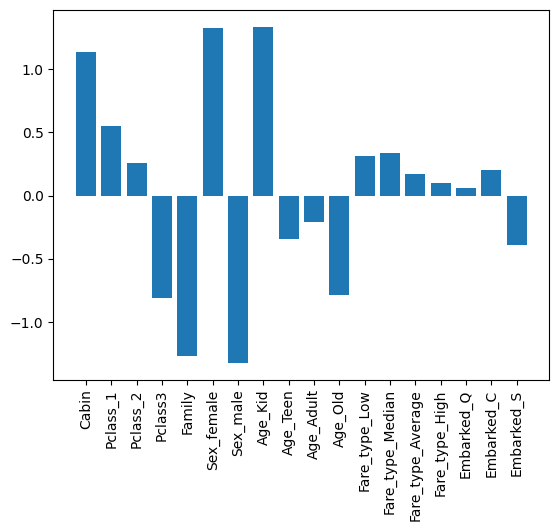

In [77]:
log = LogisticRegression()

log.fit(x_train, y_train)

importance = log.coef_[0]

data = {
    "Cabin" : importance[0],
    "Pclass_1" : importance[1],
    "Pclass_2" : importance[2],
    "Pclass_3" : importance[3],
    "Family" : importance[4],
    "Sex_female" : importance[5],
    "Sex_male" : importance[6], 
    "Age_Kid" : importance[7],
    "Age_Teen" : importance[8],
    "Age_Adult" : importance[9],
    "Age_Old" : importance[10],
    "Fare_type_Low" : importance[11],
    "Fare_type_Median" : importance[12],
    "Fare_type_Average" : importance[13],
    "Fare_type_High" : importance[14],
    "Embarked_Q" : importance[15],
    "Embarked_C" : importance[16],
    "Embarked_S" : importance[17]
}

plt.bar(data.keys(), data.values())
plt.xticks(rotation="vertical")
plt.show()


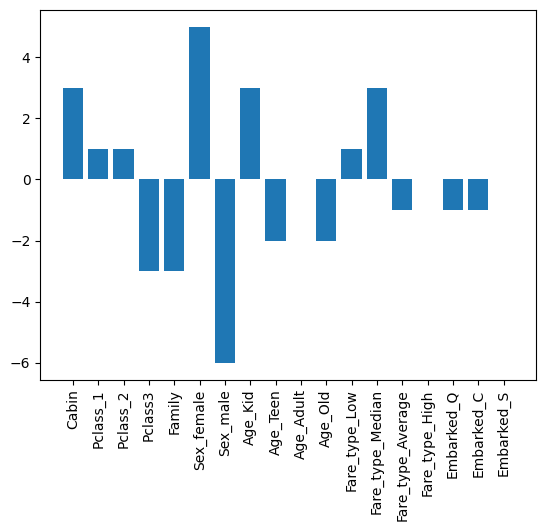

In [78]:
perc = Perceptron()

perc.fit(x_train, y_train)

importance = perc.coef_[0]

data = {
    "Cabin" : importance[0],
    "Pclass_1" : importance[1],
    "Pclass_2" : importance[2],
    "Pclass_3" : importance[3],
    "Family" : importance[4],
    "Sex_female" : importance[5],
    "Sex_male" : importance[6], 
    "Age_Kid" : importance[7],
    "Age_Teen" : importance[8],
    "Age_Adult" : importance[9],
    "Age_Old" : importance[10],
    "Fare_type_Low" : importance[11],
    "Fare_type_Median" : importance[12],
    "Fare_type_Average" : importance[13],
    "Fare_type_High" : importance[14],
    "Embarked_Q" : importance[15],
    "Embarked_C" : importance[16],
    "Embarked_S" : importance[17]
}

plt.bar(data.keys(), data.values())
plt.xticks(rotation="vertical")
plt.show()

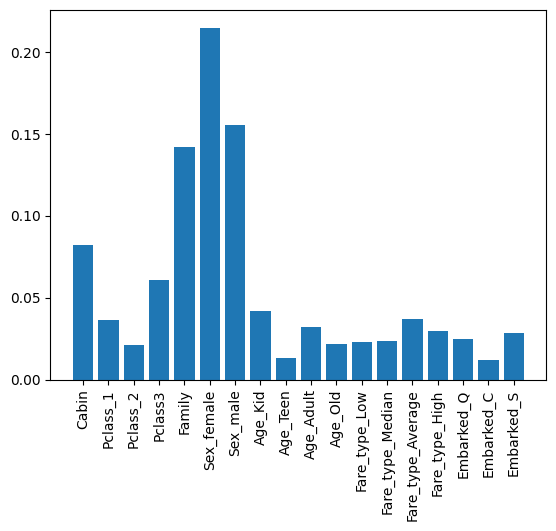

In [80]:
forest = RandomForestClassifier()

forest.fit(x_train, y_train)

importance = forest.feature_importances_

data = {
    "Cabin" : importance[0],
    "Pclass_1" : importance[1],
    "Pclass_2" : importance[2],
    "Pclass_3" : importance[3],
    "Family" : importance[4],
    "Sex_female" : importance[5],
    "Sex_male" : importance[6], 
    "Age_Kid" : importance[7],
    "Age_Teen" : importance[8],
    "Age_Adult" : importance[9],
    "Age_Old" : importance[10],
    "Fare_type_Low" : importance[11],
    "Fare_type_Median" : importance[12],
    "Fare_type_Average" : importance[13],
    "Fare_type_High" : importance[14],
    "Embarked_Q" : importance[15],
    "Embarked_C" : importance[16],
    "Embarked_S" : importance[17]
}

plt.bar(data.keys(), data.values())
plt.xticks(rotation="vertical")
plt.show()

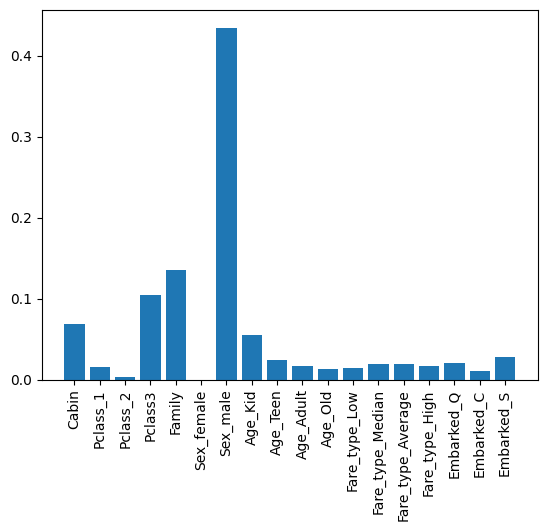

In [79]:
tree = DecisionTreeClassifier()

tree.fit(x_train, y_train)

importance = tree.feature_importances_

data = {
    "Cabin" : importance[0],
    "Pclass_1" : importance[1],
    "Pclass_2" : importance[2],
    "Pclass_3" : importance[3],
    "Family" : importance[4],
    "Sex_female" : importance[5],
    "Sex_male" : importance[6], 
    "Age_Kid" : importance[7],
    "Age_Teen" : importance[8],
    "Age_Adult" : importance[9],
    "Age_Old" : importance[10],
    "Fare_type_Low" : importance[11],
    "Fare_type_Median" : importance[12],
    "Fare_type_Average" : importance[13],
    "Fare_type_High" : importance[14],
    "Embarked_Q" : importance[15],
    "Embarked_C" : importance[16],
    "Embarked_S" : importance[17]
}

plt.bar(data.keys(), data.values())
plt.xticks(rotation="vertical")
plt.show()